In [1]:
# standard python utilities
import os
from os.path import join, exists, dirname, basename
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
# import rasterio

# mapping utilities
# import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator



In [2]:
git_dir = os.getcwd()
while basename(git_dir) != 'GitHub':
    git_dir = dirname(git_dir)
usr_dir = os.getcwd()
while basename(usr_dir) != 'Users':
    temp = basename(usr_dir)
    usr_dir = dirname(usr_dir)
usr_dir += '/'+temp
doc_dir = join(usr_dir,'Documents')
## Set up directory referencing
# Package data
gwfm_dir = join(usr_dir,'Box/research_cosumnes/GWFlowModel')
gwfm_dir

'C:\\Users/ajcalder\\Box/research_cosumnes/GWFlowModel'

In [3]:
flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
    sys.path.insert(0, flopy_dir)
    
import flopy
import flopy.utils.binaryfile as bf


In [4]:
plt_dir = join(gwfm_dir, 'Oneto_Denier/figures')

In [122]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'
if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 
loadpth +='/GWFlowModel/Cosumnes/Stream_seepage/'

# model_nam = 'inset_model'
model_nam = 'inset_oneto_denier'
model_nam = 'oneto_denier_2014_2018'

model_ws = loadpth+ model_nam

# model_ws = join(loadpth,'parallel_oneto_denier','realization000')

In [123]:
# may want to skip loading rch, evt and wel which take up a lot of memory with stress period data
load_only = ['DIS','UPW','SFR','OC']
m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
                                exe_name='mf-owhm', version='mfnwt',
                              load_only = load_only,
                              )

In [108]:
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, model_nam,'rm_only_grid.shp')
grid_p = gpd.read_file(grid_fn)
grid_p.crs='epsg:32610'
m_domain = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_p.unary_union], crs='epsg:32610')

sfrdf = pd.DataFrame(m.sfr.reach_data)
grid_sfr = grid_p.set_index(['row','column']).loc[list(zip(sfrdf.i+1,sfrdf.j+1))].reset_index(drop=True)
grid_sfr = pd.concat((grid_sfr,sfrdf),axis=1)

sfr_dir = gwfm_dir+'/SFR_data/'


In [109]:
def zone_clean(cbc,zon, ind_name,  kstpkper):
    zb = flopy.utils.ZoneBudget(cbc, zon, kstpkper)
    zb_df = zb.get_dataframes()
    # ungroup by timestep
    zb_df = zb_df.reset_index()
    names = zb_df.name.unique()
    zb_df = zb_df.pivot(index = 'totim', columns = 'name',values = 'ZONE_1')
    
    # columns to make negative
    to_cols = zb_df.columns[zb_df.columns.str.contains('TO_')]
    # multiply by -1 to have pulled out of water balance on plot
    zb_df.loc[:, to_cols] *= -1
    # correct for storage change
    # to storage is gw increase (positive)
    stor_cols = zb_df.columns[zb_df.columns.str.contains('STORAGE')]
#     zb_df.loc[:, stor_cols] *= -1
    zb_df['dSTORAGE'] = (zb_df.TO_STORAGE + zb_df.FROM_STORAGE) * -1
    zb_df = zb_df.drop(columns=stor_cols)
    zb_df = zb_df.reset_index()
    strt_date = pd.to_datetime(m.dis.start_datetime)
    zb_df.totim = strt_date+(zb_df.totim*24).astype('timedelta64[h]')
    zb_df = zb_df.set_index('totim')
    # convert 4 hr time steps to daily basis
    zb_df = zb_df.resample('D').mean()
    # summarize to monthly sum
    zb_mon = zb_df.resample('MS').sum()
    zb_mon['PERCENT_ERROR'] = zb_mon['IN-OUT']/np.mean((zb_mon.TOTAL_IN, zb_mon.TOTAL_OUT), axis=0)
    return(zb_df, zb_mon)

In [110]:
lak_shp = join(gwfm_dir,'LAK_data/floodplain_delineation')
# shapefile rectangle of the area surrounding the Dam within about 5 cells
zon_gpd = gpd.read_file(join(lak_shp,'LCRFR_ModelDom_2017/LCRFR_2DArea_2015.shp' )).to_crs('epsg:32610')

zon_cells = gpd.sjoin(grid_p,zon_gpd,how='right',predicate='within')

# filter zone budget for Blodgett Dam to just within 5 cells or so of the Dam
zon_lak = np.zeros((grid_p.row.max(),grid_p.column.max()),dtype=int)
zon_lak[zon_cells.row-1,zon_cells.column-1]=1

zon_mod = np.ones((grid_p.row.max(),grid_p.column.max()),dtype=int)

In [111]:
zon_color_dict = pd.read_csv('mf_wb_color_dict.csv',header=0, index_col='flux',skiprows=1).color.to_dict()
zon_name_dict = pd.read_csv('mf_wb_color_dict.csv',header=0, index_col='flux',skiprows=1).name.to_dict()

In [124]:
# load cbb file from any model scneario to get listing of kstpkper
cbc = join(m.model_ws, 'MF.cbc')
zb = flopy.utils.ZoneBudget(cbc, zon_mod)
kstpkper = zb.kstpkper


In [125]:
#     zb = flopy.utils.ZoneBudget(cbc, zon, kstpkper)
# zb_df = zb.get_dataframes()
# # ungroup by timestep
# zb_df = zb_df.reset_index()
# names = zb_df.name.unique()
# zb_df = zb_df.pivot(index = 'totim', columns = 'name',values = 'ZONE_1')
    

In [126]:

all_d, all_mon = zone_clean(cbc,zon_mod, 'ALL', kstpkper)
mod_cols = all_d.columns[all_d.columns.str.contains('TO_|FROM_')].values
mod_cols = mod_cols[(np.abs(all_d[mod_cols])>0).sum(axis=0).astype(bool)]


<AxesSubplot: xlabel='totim'>

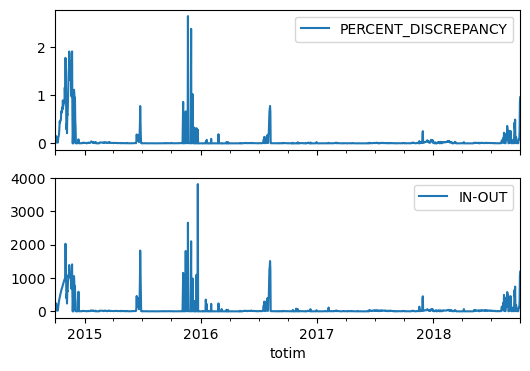

In [127]:
fig,ax = plt.subplots(2,1, figsize=(6,4), sharex=True)
all_d.plot(y='PERCENT_DISCREPANCY', ax=ax[0]) 
all_d.plot(y='IN-OUT', ax=ax[1])
# there are huge budget errors during peak flows
# there is way too much flow going in during the peak flows

In [128]:
# fig,ax = plt.subplots(1,2)

# im0 = ax[0].imshow(m.evt.evtr.array[0,0])
# plt.colorbar(im0, shrink=0.5)
# im1 = ax[1].imshow(m.evt.exdp.array[0,0])
# plt.colorbar(im1, shrink=0.5)

# fig.tight_layout()

Text(0.5, 1.0, 'Water Budget for Entire Domain')

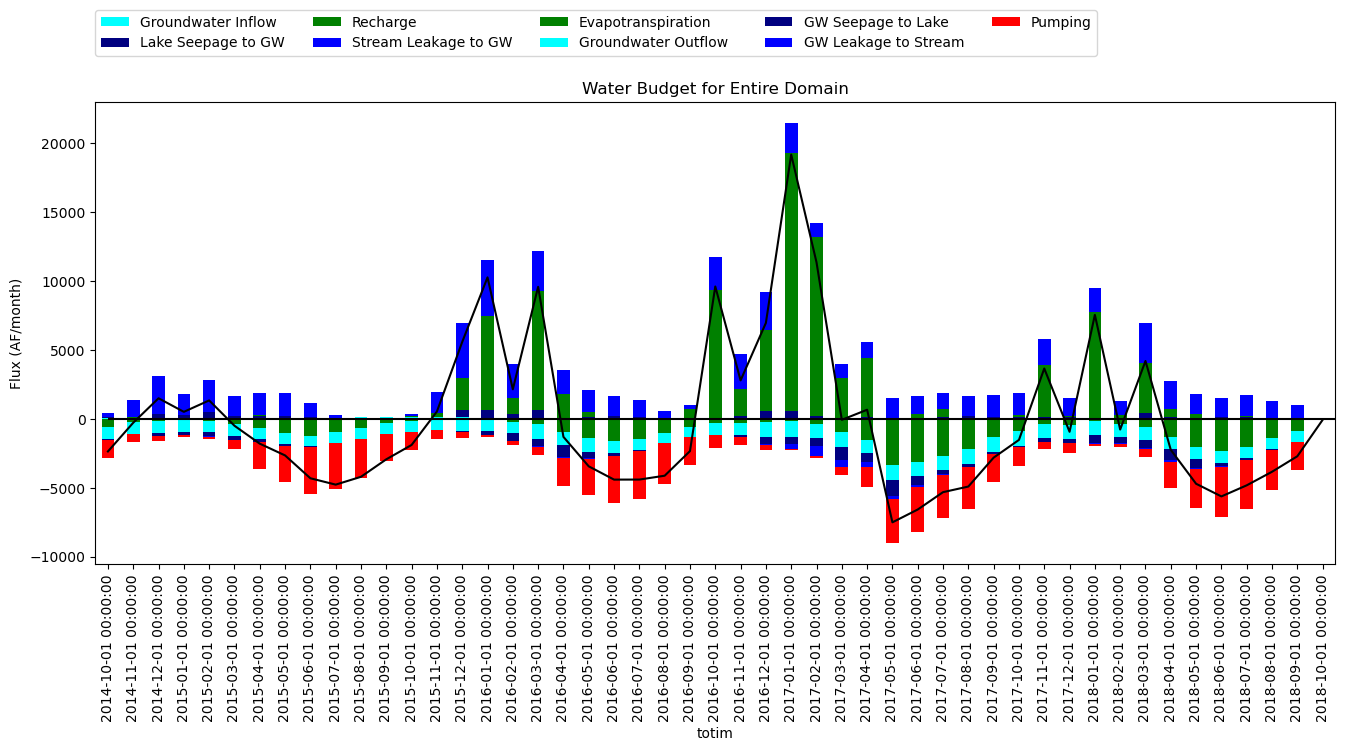

In [129]:
# convert m3 to AF
zb_mod_all_AF = (all_mon*(1/0.3048**3)*(1/43560))

fig, ax = plt.subplots(figsize=(16,6))
# bar plot xticks are plotted as values
zb_mod_all_AF.plot(y=mod_cols,
           kind='bar',ax=ax, stacked = True,
               color=[zon_color_dict[x] for x in mod_cols], label = [zon_name_dict[x] for x in mod_cols])
ax.hlines(y=0, xmin = 0, xmax = 100, color = 'black')
# lines are continuous xticks, either force datetime into strings or reuse previous xticks
ax.plot(zb_mod_all_AF.index.astype(str), zb_mod_all_AF.dSTORAGE, color='black')

plt.legend(loc=(0.0,1.1),ncol=5)
plt.ylabel('Flux (AF/month)')
plt.title('Water Budget for Entire Domain')
# plt.savefig(plt_dir+'/domain_waterbudget_'+model_type+'_AF_day.png',dpi=600,bbox_inches='tight')

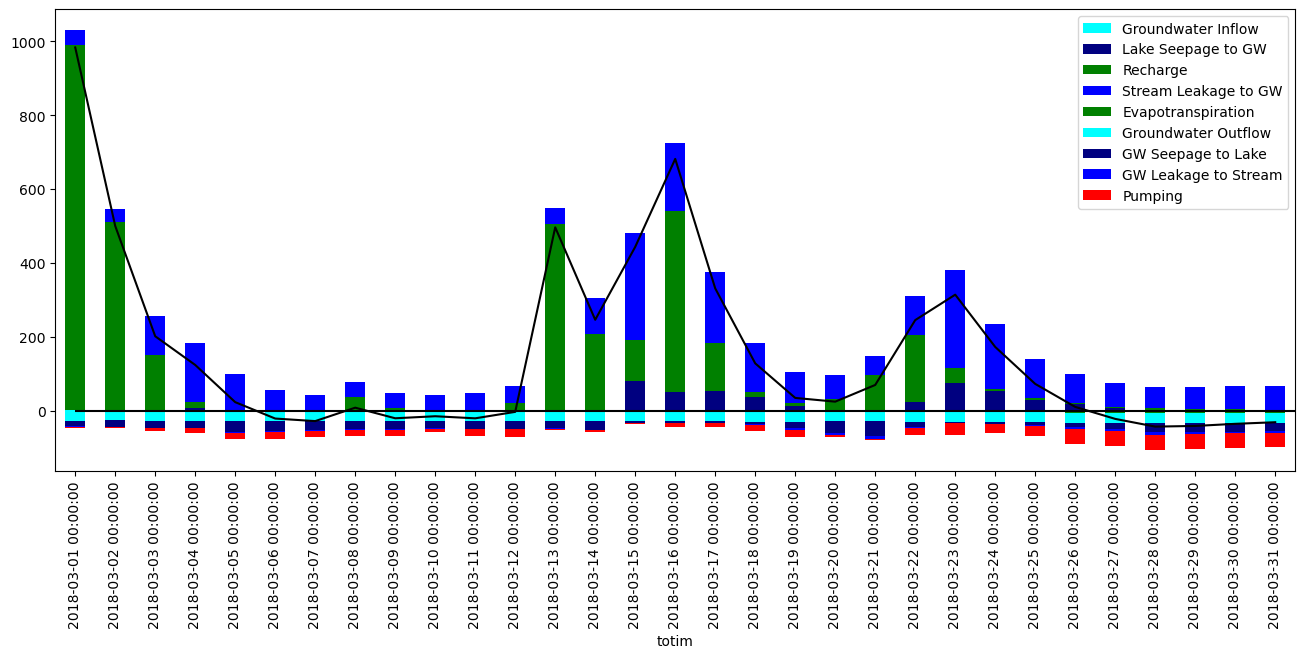

In [121]:
zb_mod_all_AF = (all_d*(1/0.3048**3)*(1/43560))
zb_mod_all_AF = zb_mod_all_AF[zb_mod_all_AF.index.month==3]

fig, ax = plt.subplots(figsize=(16,6))
# bar plot xticks are plotted as values
zb_mod_all_AF.plot(y=mod_cols,
           kind='bar',ax=ax, stacked = True,
               color=[zon_color_dict[x] for x in mod_cols], label = [zon_name_dict[x] for x in mod_cols])
ax.hlines(y=0, xmin = 0, xmax = 100, color = 'black')
# lines are continuous xticks, either force datetime into strings or reuse previous xticks
ax.plot(zb_mod_all_AF.index.astype(str), zb_mod_all_AF.dSTORAGE, color='black')


## Lake budget

In [ ]:
lak_d, lak_mon = zone_clean(cbc,zon_lak, 'LAK',kstpkper)
lak_cols = lak_d.columns[lak_d.columns.str.contains('TO_|FROM_')].values
lak_cols = lak_cols[(np.abs(lak_d[lak_cols])>0).sum(axis=0).astype(bool)]


Text(0.5, 0, 'Scenario')

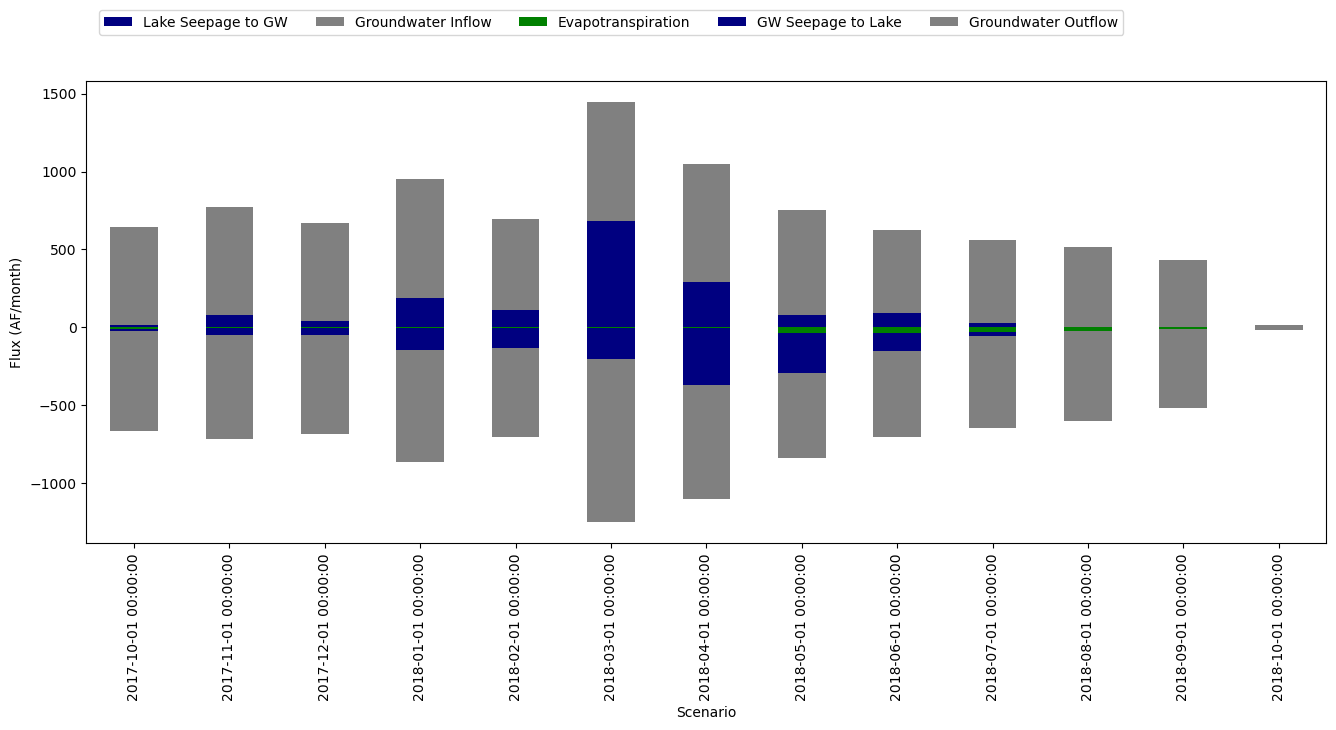

In [92]:
# convert m3/day to AF/30 days
zb_lak_all_AF = (lak_mon*(1/0.3048**3)*(1/43560))

fig, ax = plt.subplots(figsize=(16,6))
zb_lak_all_AF.plot(y=lak_cols,
           kind='bar',ax=ax, stacked = True,legend=False,
               color=[zon_color_dict[x] for x in lak_cols], label = [zon_name_dict[x] for x in lak_cols]
                  )

plt.ylabel('Flux (AF/month)')
plt.legend(loc=(0.01,1.1),ncol=5)
plt.xlabel('Scenario')
# plt.savefig(plt_dir+'/AOI_waterbudget_GW_'+model_nam+'_AF_day.png',dpi=600,bbox_inches='tight')


## Annual sum water budget

In [ ]:
def annual_WB(zb_annual,unit, zon):
    # if unit = AF convert units, else leave as m3
    if unit == 'AF':
        # ((1 ft/ 0.3048 m)^3) * (1 acre/43560 ft2)
        zb_annual = zb_annual/((0.3048**3) *43560)
    if zon == 'valley':
        cols = [ 'FROM_RECHARGE', 'FROM_ZONE_0', 'TO_ZONE_0', 'TO_WELLS']        
    elif zon == 'all':
        cols = ['FROM_CONSTANT_HEAD', 'FROM_GHB', 'FROM_RECHARGE', 'TO_CONSTANT_HEAD', 'TO_GHB', 'TO_WELLS']

    #fixes issues with line and bar plotting
    zb_annual.index = zb_annual.index.astype(str)
    
    fig, ax = plt.subplots(figsize=(16,6))
    # clean up x axis so there are not as many dates
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    zb_annual.plot(y=['dSTORAGE'],ax=ax, color = 'black')
    # define columns to plot
    
    # plot acre ft instead of meters
    zb_annual.plot(y= cols,
               kind='bar',ax=ax, stacked = True)
    plt.ylabel('Flux (ac-ft/year)')

    zb_annual.plot(y=['SUM_dSTORAGE'],ax=ax, secondary_y = True,rot=90)
    plt.xticks(rotation=90)
    ax.yaxis.set_major_locator(MaxNLocator(5)) 

    plt.ylabel('Flux (ac-ft/year)')
    plt.xlabel('Datetime')
    plt.title('Water Budget for Butte Valley')
    plt.savefig(m.model_ws+'/Plots/annualsum_WB_'+zon+'_'+unit+'.png',dpi=300,bbox_inches = 'tight')
    zb_annual.to_csv(m.model_ws+'/Plots/annualsum_WB_'+zon+'_'+unit+'.csv')

In [ ]:
annual_WB(zb_annual118,unit = 'AF',zon='valley')
annual_WB(zb_annual,unit = 'AF',zon='all')

In [ ]:
def monthly_WB(zb_df,unit, zon, wy,name):
    plt_strt = pd.to_datetime(str(wy-1)+'-10-01')
    plt_end = pd.to_datetime(str(wy)+'-9-30')
    zb_plot = zb_df.loc[(zb_df.index>plt_strt)&(zb_df.index<plt_end)]
    zb_plot.index = zb_plot.index.astype(str)
    # if unit = AF convert units, else leave as m3
    if unit == 'AF':
        # ((1 ft/ 0.3048 m)^3) * (1 acre/43560 ft2)
        zb_plot = zb_plot/((0.3048**3) *43560)

    #fixes issues with line and bar plotting
    zb_plot.index = zb_plot.index.astype(str)
    
    fig, ax = plt.subplots(figsize=(16,6))
    # clean up x axis so there are not as many dates
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    zb_plot.plot(y=['dSTORAGE'],ax=ax, color = 'black')
    ax.hlines(y=0, xmin = -1, xmax = 100, color = 'black')

    # plot acre ft instead of meters
    zb_plot.plot(y= cols,
               kind='bar',ax=ax, stacked = True)
    plt.ylabel('Flux (ac-ft/month)')

    zb_plot.plot(y=['SUM_dSTORAGE'],ax=ax, secondary_y = True,rot=90)
    plt.xticks(rotation=90)
    ax.yaxis.set_major_locator(MaxNLocator(5)) 

    plt.ylabel('Flux (ac-ft/month)')
    plt.xlabel('Datetime')
    plt.title('Water Budget for Butte Valley WY'+str(wy)+' - '+name+' Year' )
#     plt.savefig(m.model_ws+'/Plots/'+name+'_'+str(wy)+'monthlyWB_'+zon+'_'+unit+'.png',dpi=300,bbox_inches = 'tight')

In [ ]:
monthly_WB(zb_df_mon,unit='AF', zon='all', wy=1999,name='Wet')
monthly_WB(zb_df_mon,unit='AF', zon='all', wy=2005,name='Avg')
monthly_WB(zb_df_mon,unit='AF', zon='all', wy=2014,name='Dry')